In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from gflownet.gflownet import GFlowNet
from policy import ForwardPolicy, BackwardPolicy
from setGenerationEnv import SetGenerationEnv
from gflownet.utils import trajectory_balance_loss
from torch.optim import Adam
from tqdm import tqdm
import torch 

size = 4
nActions = 15
losses = []
rewards = []
flows = []


def train(batch_size, num_epochs):
    setEnv = SetGenerationEnv(size, nActions)
    forward_policy = ForwardPolicy(setEnv.state_dim, hidden_dim=32, num_actions=setEnv.num_actions)
    backward_policy = BackwardPolicy(setEnv.state_dim, num_actions=setEnv.num_actions)
    
    model = GFlowNet(forward_policy, backward_policy, setEnv)

    opt = Adam([
        {"params": model.forward_policy.parameters()},
        {"params": model.total_flow, "lr": 0.1},
    ],
    lr=5e-3)
    
    for i in (p := tqdm(range(num_epochs))):
        s0 = torch.zeros(batch_size, size).float()
        curr0 = torch.zeros(batch_size)
        s, log, traj_length = model.sample_states(s0, curr0, return_log=True)
      

        loss = trajectory_balance_loss(log.total_flow,
                                       log.rewards,
                                       log.fwd_probs,
                                       log.back_probs)
        
        flows.append(model.total_flow.item())
        rewards.append(log.rewards.mean())
        losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 10 == 0: p.set_description(f"{loss.item():.3f} T.L : {traj_length}")

    return model, losses, rewards, flows

batch_size = 64
num_epochs = 1000

model, losses, rewards, flows = train(batch_size, num_epochs)

  0%|                                                                                                                                | 0/1000 [00:00<?, ?it/s]


TypeError: only integer tensors of a single element can be converted to an index

Text(0.5, 1.0, 'Log Total Flow (logZ)')

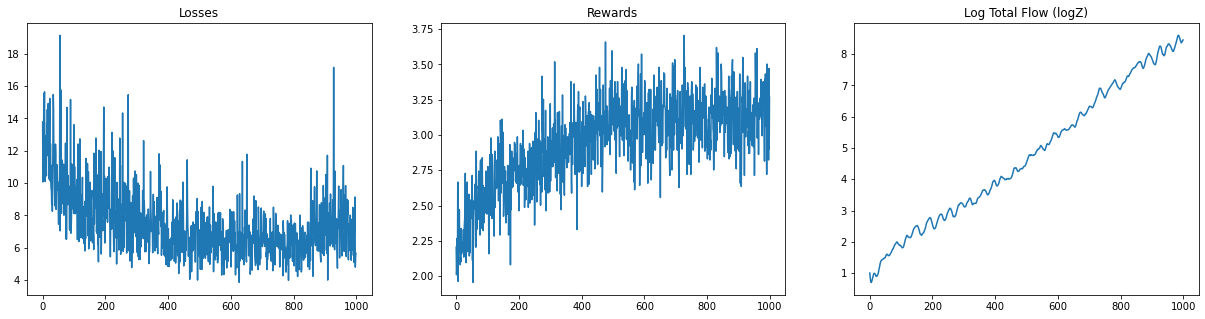

In [15]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 3, figsize=(21, 5))
ax[0].plot(losses)
ax[0].set_title("Losses")
ax[1].plot(rewards)
ax[1].set_title("Rewards")
ax[2].plot(flows)
ax[2].set_title("Log Total Flow (logZ)")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.81s/it]

torch.Size([20736, 4])


<AxesSubplot:xlabel='Frequency', ylabel='Reward'>

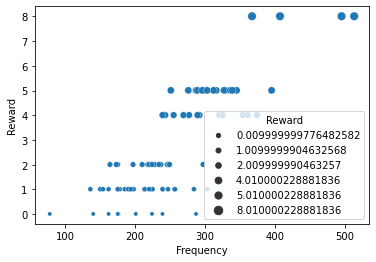

In [21]:
setEnv = SetGenerationEnv(size, nActions)
nIter = 1
terminalStates = []
for i in tqdm(range(nIter)):
    s0 = torch.zeros(12**4, size).float()
    curr0 = torch.zeros(12**4)
    s = model.sample_states(s0, curr0, return_log=False)
    terminalStates.append(s)
    
s = torch.concat(terminalStates)
print(s.shape)

import seaborn as sns
import pandas as pd

setEnv = SetGenerationEnv(size, nActions)

statesForPlot = setEnv.getStateForm(s).tolist()
rewardsForPlot = setEnv.reward(s).tolist()


stateDict = {}
for i in range(len(statesForPlot)):
    state = str(statesForPlot[i])
    if state in stateDict:
        reward, freq = stateDict[state]
        stateDict[state] = (reward, freq + 1)
    else:
        stateDict[state] = (rewardsForPlot[i], 1)

allRewards = []
freqs = []
for _ in stateDict:
    reward, freq = stateDict[_]
    allRewards.append(reward)
    freqs.append(freq)

# plt.xlim(0, 40)
sns.scatterplot(data=pd.DataFrame({'Frequency':freqs, 'Reward':allRewards}), x='Frequency', y='Reward', size='Reward')

In [22]:
for _ in stateDict:
    reward, freq = stateDict[_]
    if reward > 8:
        print(reward, _, freq)

8.010000228881836 [3.0, 1.0, 3.0, 1.0] 513
8.010000228881836 [1.0, 3.0, 1.0, 3.0] 407
8.010000228881836 [1.0, 3.0, 3.0, 1.0] 367
8.010000228881836 [3.0, 1.0, 1.0, 3.0] 495
